## **IMPORTS**|

In [745]:
#IMPORTS
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
# !pip install --upgrade reedsolo
import reedsolo as rs
from skimage.metrics import structural_similarity as compare_ssim
from scipy.signal import medfilt2d

In [746]:
fN = "CSE483 Sp24 Project Test Cases/" #folderName
img_array = [fN+'01-Getting-started.png',fN+'02-Matsawar-3edel-ya3am.png', fN+'03-Leffy-bina-ya-donya.png',
             fN+'04-Black-mirror.png',fN+'05-Caesar-cipher.png', fN+'06-Railfence-cipher.png',
             fN+'07-THE-MIGHTY-FINGER.png', fN+'08-Compresso-Espresso.png', fN+'09-My-phone-fell-while-taking-this-one-...-or-did-it.png', fN+'10-Gone-With-The-Wind.png', fN+'11-weewooweewooweewoo.png',
             fN+'12-mal7-w-felfel.png', fN+'13-2el-noor-2ata3.png',fN+'14-BANANAAA!!!.png',
             fN+'15-beast-mode-computer-vision-(this-one-is-from-wikipedia).jpg',
             fN+'16-V3-QR-Code...-can-you-do-it.png']

TEST_CASE = 14
if TEST_CASE!= 0:
    img_address = img_array[TEST_CASE-1]
else:
    print("Enter correct TEST_CASE")

## *PREPROCESSING*

In [747]:
def median_filter(img, size):
    median = cv2.medianBlur(img, size)
    return median

def smoothing_filter(img):

    return 0

def constrast_stretching(gray):
    # Calculate the minimum and maximum pixel values
    min_val = np.min(gray)
    max_val = np.max(gray)

    # Define the new minimum and maximum values for contrast stretching
    new_min = 0
    new_max = 255

    # Apply contrast stretching
    stretched_image = ((gray - min_val) / (max_val - min_val)) * (new_max - new_min) + new_min

    # Convert the image back to uint8 format
    stretched_image = np.uint8(stretched_image)
    return stretched_image


def brighten_filter(img_gray):
    brightened_img = [pixel if (pixel >= 128) else pixel + 128 for pixel in img_gray.ravel()]
    brightened_img_reshaped = np.reshape(brightened_img, img_gray.shape)
    return brightened_img_reshaped

def rotate_img(img):

    # Rotate the image
    rotated_img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    return rotated_img

def show_histogram(img):
    plt.figure(figsize=(9,8))
    plt.hist(img.ravel(), bins=256)

def sharpening_filter(img_gray, kernel_size):
    image_float32 = np.float32(img_gray)
    blurred = cv2.GaussianBlur(img_gray, (kernel_size, kernel_size), 0)
    blurred_float32 = np.float32(blurred)

    # Calculate the unsharp mask (original image - blurred image)
    unsharp_mask = cv2.subtract(image_float32, blurred_float32)

    # Add the unsharp mask to the original image to sharpen it
    sharpened = cv2.add(image_float32, unsharp_mask)
    sharpened = np.clip(sharpened, 0, 255)  # Clip values to 0-255 range
    sharpened = np.uint8(sharpened)
    return sharpened

def opening_filter(img):
    closed_img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13)))
    # plt.imshow(thresh1, cmap="grey")

    return closed_img

def get_contours(img):
    #img taken into the contours must be binarized (applying greyscale then threshold) for better accuracy

    ## *object to be found should be white and background should be black* ##

    # Find contours in the binary image
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Find the contour with the largest area (assuming it's the outer frame of the QR code)
    largest_contour = max(contours, key=cv2.contourArea)
    # Get the bounding (corner points) of the rectangle of the contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the image to the bounding rectangle to Extract the QR code region
    qr_code_frame = img[y:y+h, x:x+w]

    # Straightening into a square (assuming the frame is already rectangular)
    # Find the longer side of the rectangle
    if w > h:
        max_dim = w
    else:
        max_dim = h

    # Create a square image with dimensions equal to the maximum dimension
    square_img = np.zeros((max_dim, max_dim), dtype=np.uint8)
    # Calculate the position to paste the rectangle in the center of the square image
    x_pos = (max_dim - w) // 2
    y_pos = (max_dim - h) // 2
    # Paste the rectangle onto the square image
    square_img[y_pos:y_pos+h, x_pos:x_pos+w] = qr_code_frame
    return square_img

def invert_qr(img):
    inverted_img = cv2.bitwise_not(img)
    return inverted_img

def adaptive_threshold(img, blockSize, C):
    adptv_threshed_img = cv2.adaptiveThreshold(
    src=img,
    maxValue=255,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # read: https://docs.opencv.org/3.4/d7/d1b/group__imgproc__misc.html#gaa42a3e6ef26247da787bf34030ed772c
    thresholdType=cv2.THRESH_BINARY,
    blockSize=blockSize,  # NxN block size (odd) to perform adaptive threshold on
    C=C  # Constant subtracted from the mean or weighted mean
    )

    return adptv_threshed_img


def flip_image(img):
    img = cv2.flip(img,1)
    return img

def fourier(image):
    dft_img = np.fft.fft2(image)
    dft_img_shift = np.fft.fftshift(dft_img)

    return dft_img_shift

def histogram_equalizer(img):
    equalized_img = cv2.equalizeHist(img)
    return equalized_img

def shift_image(image, dx, dy):
    shifted_image = np.roll(image, dy, axis=0)  # Shift rows
    shifted_image = np.roll(shifted_image, dx, axis=1)  # Shift columns
    return shifted_image

def replicate_padding(image, padding_size):
    return cv2.copyMakeBorder(image, padding_size, padding_size, padding_size, padding_size, cv2.BORDER_REPLICATE)

def zero_padding(image, padding_size):
    return cv2.copyMakeBorder(image, padding_size, padding_size, padding_size, padding_size, cv2.BORDER_CONSTANT, value=0)

def ones_padding(image, padding_size):
    return cv2.copyMakeBorder(image, padding_size, padding_size, padding_size, padding_size, cv2.BORDER_CONSTANT, value=255)

def mirror_padding(image, padding_size):
    return cv2.copyMakeBorder(image, padding_size, padding_size, padding_size, padding_size, cv2.BORDER_REFLECT)

def straighten_image(image, edges_hough_lines):

    # Calculate rotation angle
    angle_sum = 0
    for line in edges_hough_lines:
        x1, y1, x2, y2 = line[0]
        angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
        angle_sum += angle
    rotation_angle = angle_sum / len(edges_hough_lines)

    image = ones_padding(image,0)
    print("Rotation angle:", rotation_angle)
    # Reverse the rotation
    (h, w) = image.shape[:2]
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, -8, 1.0)
    rotated_image = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR, borderValue=(255, 255, 255))
    return rotated_image


def binary_threshold(img, threshold):
    _, thresholded_image = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
    return thresholded_image


## *Filter functions*

In [748]:
def give_me_circle_mask_nowww(mask_size, radius):
    mask = np.zeros(mask_size)
    cy = mask.shape[0] // 2
    cx = mask.shape[1] // 2
    return cv2.circle(mask, (cx,cy), radius, (255,255,255), -1).astype(np.uint8)

def try_lowpass(dft_img, limit, gaussian: bool = False):
    mask = give_me_circle_mask_nowww(dft_img.shape, limit)
    if (gaussian):
        mask = cv2.GaussianBlur(mask, (21,21), 0)
    dft_img_shifted = np.fft.fftshift(dft_img)
    dft_img_shifted_lowpass = np.multiply(dft_img_shifted, mask)
    # Step 3: Convert back to spatial domain
    f_ishift = np.fft.ifftshift(dft_img_shifted_lowpass)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    return img_back

def try_highpass(dft_img, limit, gaussian: bool = False, keep_dc: bool = False):
    mask = ~give_me_circle_mask_nowww(dft_img.shape, limit)
    if (gaussian):
        mask = cv2.GaussianBlur(mask, (21,21), 0)
    if (keep_dc):
        mask[dft_img.shape[0]//2, dft_img.shape[1]//2] = 255
    dft_img_shifted = np.fft.fftshift(dft_img)
    dft_img_shifted_highpass = np.multiply(dft_img_shifted, mask)
    # Step 3: Convert back to spatial domain
    f_ishift = np.fft.ifftshift(dft_img_shifted_highpass)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)

    # Normalize pixel values to range [0, 255]
    img_back = cv2.normalize(img_back, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    return img_back

def plot_shifted_fft_and_ifft(dft_img_shifted):
    img = np.fft.ifft2(np.fft.ifftshift(dft_img_shifted))
    fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)
    ax1.set(yticks=[0, img.shape[0]//2, img.shape[0] - 1], yticklabels=[-img.shape[0]//2, 0, img.shape[0]//2 - 1])
    ax1.set(xticks=[0, img.shape[1]//2, img.shape[1] - 1], xticklabels=[-img.shape[1]//2, 0, img.shape[1]//2 - 1])
    ax1.imshow(np.abs(dft_img_shifted)**0.1, cmap = 'gray')
    ax2.imshow(np.abs(img), cmap = 'gray')
    return dft_img_shifted

In [749]:
def biggestContour (contours):
    biggest=np.array([])

    max_area=0
    for i in contours:
        area=cv2.contourArea(i)
        if area>1000:
            peri=cv2.arcLength(i,True)
            approx=cv2.approxPolyDP(i,0.02*peri,True)
            if area > max_area and len(approx)==4:
                biggest=approx
                max_area=area
    return biggest,max_area
def reorder(myPoints):
    myPoints=myPoints.reshape((4,2))
    myPointsNew=np.zeros((4,1,2),dtype=np.int32)
    add=myPoints.sum(1)
    myPointsNew[0]=myPoints[np.argmin(add)]
    myPointsNew[3]=myPoints[np.argmax(add)]
    diff=np.diff(myPoints,axis=1)
    myPointsNew[1]=myPoints[np.argmin(diff)]
    myPointsNew[2]=myPoints[np.argmax(diff)]
    return myPointsNew

### Finding the placement boxes contours

2665.5
Box  1 Width:  119 , Height:  98
Bounding Box Size: (width=119, height=98)
max value 616
min value 535
Rotate flag:  False
Mirror flag:  False
Bounding Box 1: (x=616, y=535)


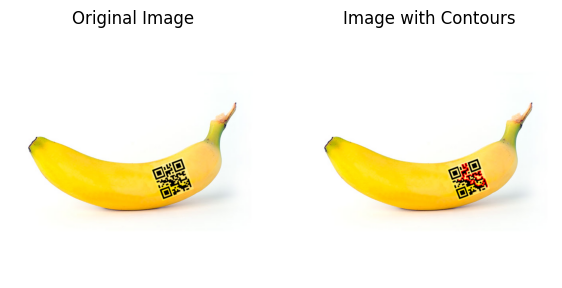

In [750]:
try:
    fig, axes = plt.subplots(1, 2, figsize=(7, 7))
    RotateFlag = False
    MirrorFlag = False
    image = cv2.imread(img_address)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Filter contours with area greater than 120,000
    filtered_contours = [contour for contour in contours if cv2.contourArea(contour) <= 120000]

    # If all contours have area greater than 120,000, consider original contours
    if len(filtered_contours) == 0:
        filtered_contours = contours

    # Find the maximum area among the filtered contours
    max_area = max(cv2.contourArea(contour) for contour in filtered_contours)

    print(max_area)
    largest_contours = [contour for contour in filtered_contours if cv2.contourArea(contour) > 0.9 * max_area]
    # largest_contours = [contour for contour in contours]

    bounding_box_coordinates = []
    bounding_box_width = 0
    bounding_box_height = 0
    counter = 1
    for contour in largest_contours:
        x, y, w, h = cv2.boundingRect(contour)
        bounding_box_coordinates.append((x, y))
        bounding_box_width = w
        bounding_box_height = h
        print("Box ", counter, "Width: ", bounding_box_width, ", Height: ",bounding_box_height)
        counter+=1

    print(f"Bounding Box Size: (width={bounding_box_width}, height={bounding_box_height})")
    all_values = [value for pair in bounding_box_coordinates for value in pair]
    max_value = max(all_values)
    print("max value", max_value)
    min_value = min(all_values)
    print("min value", min_value)

    threshold = 10  # You can adjust this threshold as needed

    # Create arrays for values around min_value and max_value within the threshold
    min_value_array = list(range(min_value - threshold, min_value + threshold + 1))
    max_value_array = list(range(max_value - threshold, max_value + threshold + 1))

    if len(bounding_box_coordinates)>1:
        # Check if any point has x == max_value and y == max_value
        max_value_points = any(x == max_value and y == max_value for x, y in bounding_box_coordinates)

        # Check if any point has x == min_value and y == max_value
        min_value_points = any((x in min_value_array and y in max_value_array) for x, y in bounding_box_coordinates)

        min_value = any(x == min_value and y == min_value for x, y in bounding_box_coordinates)
        # Set RotateFlag based on conditions
        if max_value_points and min_value_points:
            RotateFlag = True
        if not min_value_points:
            MirrorFlag = True


    print("Rotate flag: ", RotateFlag)
    print("Mirror flag: ", MirrorFlag)

    for i, (x, y) in enumerate(bounding_box_coordinates):
        print(f"Bounding Box {i + 1}: (x={x}, y={y})")
    image_with_contours = image.copy()
    cv2.drawContours(image_with_contours, largest_contours, -1, (0, 0, 255), 2)
    image_with_contours_rgb = cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB)
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    if RotateFlag == True:
        axes[1].imshow(image_with_contours_rgb)
        axes[1].set_title('Image with Contours after rotations')
        axes[1].axis('off')
    else:
            # Plot the image with contours
        axes[1].imshow(image_with_contours_rgb)
        axes[1].set_title('Image with Contours')
        axes[1].axis('off')
    plt.show()
except Exception as e:
    print("Error:", e)
    # return none

In [751]:
def detect_and_remove_sin_noise(image):
    if len(image.shape) > 2:
        image = np.mean(image, axis=2)
    # Compute the 2D discrete Fourier Transform
    dft = np.fft.fft2(image)

    # Shift the zero-frequency component to the center of the spectrum
    dft_shift = np.fft.fftshift(dft)

    # Compute the magnitude spectrum
    magnitude_spectrum = np.abs(dft_shift)

    # Threshold the magnitude spectrum to detect significant peaks
    threshold = 0.1 * np.max(magnitude_spectrum)
    peaks = np.where(magnitude_spectrum > threshold)

    # Convert the peak coordinates to frequency space
    rows, cols = image.shape
    center_row, center_col = rows // 2, cols // 2
    frequencies = np.array(peaks) - np.array([[center_row], [center_col]])

    sineFlag = False

    # Check if only one sinusoidal frequency is detected
    if len(frequencies[0]) <= 3 and len(frequencies[0]>0) :
        # Print detected sinusoidal noise frequencies
        print("Detected sinusoidal noise frequencies:")
        for freq in zip(frequencies[0], frequencies[1]):
             print("Frequency: {},{} (in pixels)".format(freq[0], freq[1]))
        # Remove the detected frequency from the shifted DFT
        freq_row, freq_col = frequencies[0][0], frequencies[1][0]
        dft_shift[center_row + freq_row, center_col + freq_col] = 0
        dft_shift[center_row - freq_row, center_col - freq_col] = 0

        # Compute the inverse shift to prepare for inverse FFT
        dft_unshifted = np.fft.ifftshift(dft_shift)

        # Compute the inverse 2D discrete Fourier Transform
        filtered_image = np.fft.ifft2(dft_unshifted).real
        print(type(frequencies))

        # Normalize pixel values to range [0, 255]
        img_back = cv2.normalize(filtered_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        if frequencies.size == 2 and frequencies[0] == 0 and frequencies[1] == 0:
            sineFlag = False
        elif (0, 1) in zip(frequencies[0], frequencies[1]) and (0, -1) in zip(frequencies[0], frequencies[1]):
            sineFlag = False
        else:
            sineFlag = True
        return img_back, sineFlag
    else:
        print("More than one sinusoidal frequency detected. Skipping noise removal.")
        return image, sineFlag

In [752]:
def warp_affining_procedure(img, canny_threshold1, canny_threshold2, theta_rad, threshold, minLineLength, maxLineGap, px, py):

    edges_img = img
    # Apply Canny edge detection
    edges_canny = cv2.Canny(image=edges_img, apertureSize=3, threshold1=canny_threshold1, threshold2=canny_threshold2, L2gradient=True)

    # Define Hough Transform parameters using sliders
    rho = 1               # @param {type:"slider", min:1, max:100, step:1}
    theta_rad = theta_rad    # @param {type:"slider", min:0.00001, max:0.1, step:0.00001}
    threshold = threshold       # @param {type:"slider", min:0, max:400, step:1}
    minLineLength = minLineLength    # @param {type:"slider", min:0, max:800, step:1}
    maxLineGap = maxLineGap

    # Detect lines using Hough Transform
    edges_hough_lines = cv2.HoughLinesP(edges_canny, rho, theta_rad, threshold, None, minLineLength, maxLineGap)

    # Calculate rotation angle
    # angle_sum = 0
    # for line in edges_hough_lines:
    #     x1, y1, x2, y2 = line[0]
    #     angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
    #     angle_sum += angle
    # rotation_angle = angle_sum / len(edges_hough_lines)
    # if rotation_angle<0:
    #     shape_image = ones_padding(edges_img,0)
    #     print("Rotation angle:", rotation_angle)
    #     # Reverse the rotation
    #     (shape_image_height,shape_image_width) = shape_image.shape[:2]
    #     center = (shape_image_width / 2, shape_image_height / 2)
    #     M = cv2.getRotationMatrix2D(center, -8, 1.0)
    #     rotated_image = cv2.warpAffine(image, M, (shape_image_width, shape_image_height), flags=cv2.INTER_LINEAR, borderValue=(255,255,255))
    #     plt.imshow(rotated_image)
    #     return rotated_image

    # Create an image to draw the detected lines
    edges_hough = cv2.cvtColor((edges_img // 3) * 2, cv2.COLOR_GRAY2BGR)

    # Draw the detected lines on a copy of the original image
    image_with_lines = edges_img.copy()

    # Draw the detected lines on the image
    if edges_hough_lines is not None:
        for line in edges_hough_lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 0, 255), 2)

    img_gray_threshed = cv2.adaptiveThreshold(src=image_with_lines,
            maxValue=255,
            adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            thresholdType=cv2.THRESH_BINARY_INV,
            blockSize=105,
            C=1
    )
    heightImg=924
    widthImg=924
    imgContours=image_with_lines.copy()
    imgBigContour=image_with_lines.copy()
    contours, hierarchy, =cv2.findContours(img_gray_threshed,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(imgContours,contours,-1,(255,50,0),10)
    biggest,maxArea=biggestContour(contours)
    if biggest.size !=0:
        biggest=reorder(biggest)
        cv2.drawContours(imgBigContour,biggest,-1,(0,255,0),20)
        if biggest.size != 0:
            biggest[-1][0][0] += px  # Add 20 pixels to x-coordinate of the last point
            biggest[-1][0][1] += py # Add 20 pixels to y-coordinate of the last point

        for point in biggest:
            x, y = point[0]
            # cv2.circle(imgContours, (x, y), 10, (0, 0, 255), -1)
            print(f"Corner Point: ({x}, {y})")
        pts1=np.float32(biggest)
        pts2=np.float32([[0,0],[widthImg,0],[0,heightImg],[widthImg,heightImg]])
        matrix=cv2.getPerspectiveTransform(pts1,pts2)
        imgWarpedgrey=cv2.warpPerspective(edges_img,matrix,(widthImg,heightImg))
        if check_valid_image(imgWarpedgrey):
            # square_se = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 13))
            # edges_img = cv2.dilate(edges_img, square_se)
            return edges_img, edges_hough_lines
        else:
            print("Image got warped")
            return imgWarpedgrey, edges_hough_lines
    else:
        print("Image did not get warped")
        return edges_img, edges_hough_lines
        # imgDetectedDigits=imgBlank.copy()


In [753]:
def check_valid_image(img):
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    black_pixels = hist[0:175]
    white_pixels = hist[175:256]
    NotValid = False
    # Calculate total pixels in black and white histograms
    total_black_pixels = int(np.sum(black_pixels))
    total_white_pixels = int(np.sum(white_pixels))

    if total_black_pixels>total_white_pixels:
        # Compute the difference
        difference = total_black_pixels - total_white_pixels
        if difference>600000:
            NotValid = True
    else:
        difference = total_white_pixels - total_black_pixels
        if difference>600000:
            NotValid = True

    return NotValid

In [754]:
def check_histogram_equalizer(img):
    hist = cv2.calcHist([img],[0],None,[256],[0,256])

    black_pixels = hist[0:175]
    white_pixels = hist[175:256]
    EqualizeFlag = False
    # Calculate total pixels in black and white histograms
    total_black_pixels = int(np.sum(black_pixels))
    total_white_pixels = int(np.sum(white_pixels))


    if total_black_pixels>total_white_pixels:
        # Compute the difference
        difference = total_black_pixels - total_white_pixels
        if difference>980000:
            EqualizeFlag = True
    else:
        difference = total_white_pixels - total_black_pixels
        if difference>980000:
            EqualizeFlag = True

    print("Total black pixels:", total_black_pixels)
    print("Total white pixels:", total_white_pixels)
    print("Difference:", difference)
    return EqualizeFlag

def check_for_erosion(img):
    hist = cv2.calcHist([img],[0],None,[256],[0,256])

    black_pixels = hist[0:175]
    white_pixels = hist[175:256]
    ErosionFlag = False
    DilationFlag = False
    # Calculate total pixels in black and white histograms
    total_black_pixels = int(np.sum(black_pixels))
    total_white_pixels = int(np.sum(white_pixels))
    print("Total black pixels after preprocessing:", total_black_pixels)
    print("Total white pixels after preprocessing:", total_white_pixels)
    if total_black_pixels>total_white_pixels:
        # Compute the difference
        difference = total_black_pixels - total_white_pixels
        if difference>480000:
            ErosionFlag = False
            DilationFlag = True

    elif total_black_pixels<total_white_pixels:
        difference = total_white_pixels - total_black_pixels
        if difference>400000:
            ErosionFlag = True
            DilationFlag = False

    return ErosionFlag, DilationFlag

In [755]:
def print_histogram_as_list(image):
    # Calculate histogram
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])

    # Convert histogram to list
    hist_list = hist.flatten().tolist()

    # Print histogram as list
    print("Histogram as list:")
    for i, freq in enumerate(hist_list):
        print(f"Bin {i}: {int(freq)}")

def find_max_min_bins(hist):
    max_bin = 0
    min_bin = 255
    for i in range(len(hist)):
        if hist[i] > 0:
            if i > max_bin:
                max_bin = i
            if i < min_bin:
                min_bin = i
    return max_bin, min_bin

def threshold_image(image,hist, max_bin, min_bin):
    threshold_value = min_bin
    flag = False
    for bin in range(min_bin+1, max_bin):
        if hist[bin] > 0:
            flag = True
            break
    if flag:
        temp = 0
        for bin in range(min_bin+1, max_bin):
            if hist[bin] > 0:
                if hist[bin] > 30000 and hist[bin] > temp:
                    threshold_value = bin
                    temp = hist[bin]
        if temp == 0:
          threshold_value = 128
    print("Threshold value: ", threshold_value)
    _, thresholded_image = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)
    return thresholded_image

def check_for_blurring(image):
    blurringFlag = False
    # Calculate the histogram
    hist = cv2.calcHist([image],[0],None,[256],[0,256])
    # print_histogram_as_list(image)
    # Extract the bins with non-zero counts
    non_zero_bins = np.sum(hist > 1000)

    if non_zero_bins>245:
        blurringFlag = True
    return blurringFlag

def check_for_blurring_and_sharpening(image):
    flag = False
    blurringFlag = False
    sharpeningFlag = False
    mean =0
    # Calculate the histogram
    hist = cv2.calcHist([image],[0],None,[256],[0,256])
    # print_histogram_as_list(image)
    # Extract the bins with non-zero counts
    max_bin = 0
    min_bin = 255
    for i in range(len(hist)):
        if hist[i] > 0:
            if i > max_bin:
                max_bin = i
            if i < min_bin:
                min_bin = i
    non_zero_bins = np.sum(hist > 1000)
    for bin in range(min_bin+1, max_bin):
        if hist[bin] > 0:
            flag = True
            break
    if flag and non_zero_bins>245:
        sum = 0
        for bin in range(min_bin+1, max_bin):
          sum+=hist[bin]
        mean = sum/(non_zero_bins-2)

    if 1000 < mean < 3000 and flag and non_zero_bins>245:
        blurringFlag = True
    elif mean> 3000 and flag and non_zero_bins>245:
        sharpeningFlag = True

    return blurringFlag, sharpeningFlag

def checkInversion(image):
    black_count=0
    white_count=0
    invertFlag=False
    hist = cv2.calcHist([image],[0],None,[256],[0,256])
    max,min=find_max_min_bins(hist)
    # print_histogram_as_list(image)
    if (max-min) <30:
      return False
    for i in range(0,128):
      if hist[i]>0:
        black_count = black_count+1
    for i in range(128,256):
      if hist[i]>0:
        white_count = white_count+1
    if black_count > white_count:
      invertFlag=True
    return invertFlag

#### **Importing image and binarizing (making it either 0 or 255)**

# *PREPROCESSING*

Detected sinusoidal noise frequencies:
Frequency: 0,0 (in pixels)
<class 'numpy.ndarray'>
Total black pixels: 16525
Total white pixels: 983475
Difference: 966950
Corner Point: (574, 563)
Corner Point: (695, 517)
Corner Point: (622, 681)
Corner Point: (736, 635)
Image got warped
Threshold value:  128
Total black pixels after preprocessing: 461056
Total white pixels after preprocessing: 392720


(-0.5, 923.5, 923.5, -0.5)

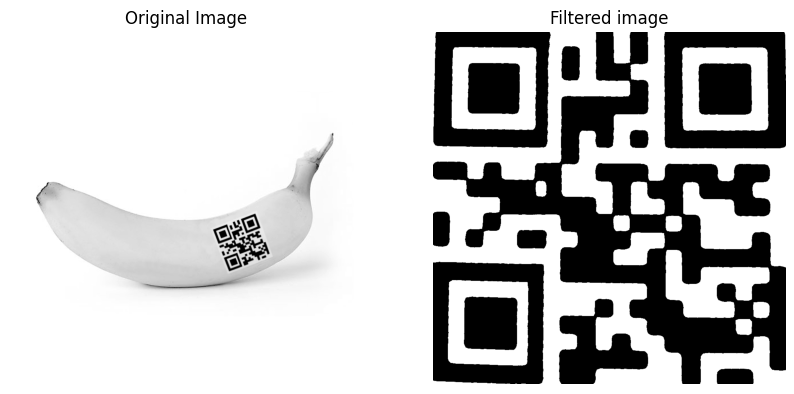

In [756]:
image = cv2.imread(img_address, cv2.IMREAD_GRAYSCALE)
img = cv2.imread(img_address, cv2.IMREAD_GRAYSCALE)
test_case = TEST_CASE
# GENERIC TEST CASES: 1,3,5,6,7,8,10,11,12,13,14,15,16
# **************************************************************#
# GENERIC PREPROCESSING

# img = cv2.GaussianBlur(img, (5, 5), 1)  # makes image blur
# img = cv2.Canny(img, 10, 50)  # makes image canny
img, sineFlag = detect_and_remove_sin_noise(img) # check and remove sine waves

EqualizeFlag = check_histogram_equalizer(img) #check if image need histogram_equalizer
BlurringFlag, SharpeningFlag = check_for_blurring_and_sharpening(img)
invertFlag = checkInversion(img)

if invertFlag:
    print("Image got inverted")
    img = invert_qr(img)

if EqualizeFlag:
    print("Image got histogram equalized")
    img = histogram_equalizer(img)

if RotateFlag:
   print("Image got rotated")
   img = cv2.rotate(image, cv2.ROTATE_180)

if BlurringFlag and not SharpeningFlag:
    print("Image got blurred")
    img = median_filter(img,31)

if SharpeningFlag and not BlurringFlag:
    print("Image got sharpened")
    sharpeninig_kernel = np.array([[-3,-3,-3],[-3,27,-3],[-3,-3,-3]])
    img = cv2.filter2D(image,-1, sharpeninig_kernel)

if MirrorFlag:
    img = flip_image(img)

# ******************************************************************************* #
if test_case==2:
    image_padding = ones_padding(img,50)
    img, _ = warp_affining_procedure(image_padding, canny_threshold1= 100,canny_threshold2 = 120, theta_rad= 0.07454, threshold= 100, minLineLength=50,maxLineGap= 10, px= 0, py= 0)
    img = straighten_image(image, _)

# ******************************************************************************* #
elif test_case == 13:
    # Apply binary thresholding to make it black and white
    _, binary_image = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

    # Apply erosion to fill in missing parts and remove noise
    kernel_size = 40  # Change the size of the kernel here
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    eroded_image = cv2.erode(binary_image, kernel, iterations=1)

    dilation_kernel_size = 33  # Change the size of the dilation kernel here
    dilation_kernel = np.ones((dilation_kernel_size, dilation_kernel_size), np.uint8)
    img = cv2.dilate(eroded_image, dilation_kernel, iterations=1)
# ******************************************************************************* #


# GENERIC PREPROCESSING
if not EqualizeFlag and not SharpeningFlag and not sineFlag and not BlurringFlag:
    img, _ = warp_affining_procedure(img, canny_threshold1= 650,canny_threshold2 = 660, theta_rad= 0.00119, threshold= 25, minLineLength=71,maxLineGap= 75, px= 2.5, py= 5)

max_threshold,min_threshold = find_max_min_bins(cv2.calcHist([img], [0], None, [256], [0, 256]))
img = threshold_image(img,cv2.calcHist([img], [0], None, [256], [0, 256]),max_threshold,min_threshold)

ErosionFlag, DilationFlag = check_for_erosion(img)
if ErosionFlag and not DilationFlag:
    kernel_size = 20  # Change the size of the kernel here
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    img = cv2.erode(img, kernel, iterations=1)

# ***************************************************** #

fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(img, cmap = 'gray')
axes[1].set_title('Filtered image')
axes[1].axis('off')

Differences between bounding boxes:
    Between Bounding Box 1 and Bounding Box 2: (x=613, y=-609)
    Between Bounding Box 2 and Bounding Box 3: (x=-603, y=-1)
Bounding Box 1: (x=38, y=651), Size: (width=212, height=225)
Bounding Box 2: (x=651, y=42), Size: (width=227, height=219)
Bounding Box 3: (x=48, y=41), Size: (width=223, height=218)
Qr code version:  1


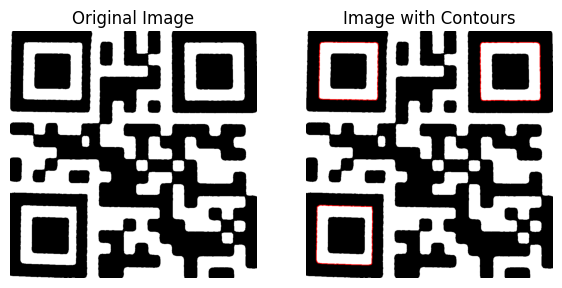

In [757]:
import cv2
import matplotlib.pyplot as plt

try:
    QR_CODE_VERSION = 1
    fig, axes = plt.subplots(1, 2, figsize=(7, 7))
    edges = cv2.Canny(img, 400, 500)
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_area = max(cv2.contourArea(contour) for contour in contours)
    largest_contours = [contour for contour in contours if cv2.contourArea(contour) > 0.9 * max_area]

    bounding_box_sizes = []
    bounding_box_coordinates = []

    for contour in largest_contours:
        x, y, w, h = cv2.boundingRect(contour)
        bounding_box_sizes.append((w, h))
        bounding_box_coordinates.append((x, y))

    if len(bounding_box_coordinates) > 1:
        x_diffs = [x2 - x1 for (x1, _), (x2, _) in zip(bounding_box_coordinates[:-1], bounding_box_coordinates[1:])]
        y_diffs = [y2 - y1 for (_, y1), (_, y2) in zip(bounding_box_coordinates[:-1], bounding_box_coordinates[1:])]

        print("Differences between bounding boxes:")
        for i, (x_diff, y_diff) in enumerate(zip(x_diffs, y_diffs)):
            print(f"    Between Bounding Box {i + 1} and Bounding Box {i + 2}: (x={x_diff}, y={y_diff})")

    for i, (x, y) in enumerate(bounding_box_coordinates):
        print(f"Bounding Box {i + 1}: (x={x}, y={y}), Size: (width={bounding_box_sizes[i][0]}, height={bounding_box_sizes[i][1]})")
        box_width = bounding_box_sizes[0][0]
        box_height = bounding_box_sizes[0][1]


    # if len(bounding_box_coordinates)>1:
        # if x_diffs >= -750 or x_diffs <= 750 or y_diffs >= -750 or y_diffs <= 750:
        #     QR_CODE_VERSION = 3
    # else:
    if box_width*box_height <= 43000 and box_height*box_width >= 3000:
            QR_CODE_VERSION = 3

    print("Qr code version: ", QR_CODE_VERSION)
    imgrgb = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    image_with_contours = imgrgb.copy()
    cv2.drawContours(image_with_contours, largest_contours, -1, (0, 0, 255), 2)
    image_with_contours_rgb = cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB)

    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    axes[1].imshow(image_with_contours_rgb)
    axes[1].set_title('Image with Contours')
    axes[1].axis('off')
    plt.show()
except Exception as e:
    print("Error:", e)
    # return none


## Use quiet zone to detect code area
Simply go through white rows and columns until you find the first black pixel from the left, from the right, from the top, and from the bottom.

In [758]:
start_row = -1
start_col = -1
end_row = -1
end_col = -1
ERROR_LEVEL = 20
for row_index, row in enumerate(img):
    non_white_count = 0
    # Checking the current row and the 10 rows below it
    for i in range(row_index, min(row_index + ERROR_LEVEL, img.shape[0])):
        if not all(pixel == 255 for pixel in img[i]):
            non_white_count += 1
            if non_white_count >= ERROR_LEVEL:
                start_row = row_index
                break
    if start_row != -1:
        break

for row_index, row in enumerate(img[::-1]):
    non_white_count = 0
    # Checking the current row and the 20 rows below it
    for i in range(row_index, min(row_index + ERROR_LEVEL, img.shape[0])):
        if not all(pixel == 255 for pixel in img[i]):
            non_white_count += 1
            if non_white_count >= ERROR_LEVEL:
                end_row = img.shape[0] - row_index
                break
    if end_row != -1:
        break

for col_index, col in enumerate(cv2.transpose(img)):
    non_white_count = 0
    # Checking the current row and the 20 rows below it
    for i in range(col_index, min(col_index + ERROR_LEVEL, img.shape[0])):
        if not all(pixel == 255 for pixel in img[i]):
            non_white_count += 1
            if non_white_count >= ERROR_LEVEL:
                start_col = col_index
                break
    if start_col != -1:
        break

for col_index, col in enumerate(cv2.transpose(img)[::-1]):
    non_white_count = 0
    # Checking the current row and the 10 rows below it
    for i in range(col_index, min(col_index + ERROR_LEVEL, img.shape[0])):
        if not all(pixel == 255 for pixel in img[i]):
            non_white_count += 1
            if non_white_count >= ERROR_LEVEL:
                end_col = img.shape[1] - col_index
                break
    if end_col != -1:
        break
start_row = start_col = max(start_row, start_col)
end_row = end_col = max(end_col,end_row)

# qr_code_version = 1
qr_code_version_grids = 0

if QR_CODE_VERSION == 1:
    qr_code_version_grids = 21
elif QR_CODE_VERSION == 3:
    qr_code_version_grids = 29

# print(start_row)
print("qr version: ", QR_CODE_VERSION, "grid size: ", qr_code_version_grids)
startFlag = False
if start_col<qr_code_version_grids:
    startFlag = True

while (end_col - start_col) % qr_code_version_grids != 0:
    if startFlag:
        start_col +=1
    else:
        end_col -= 1

startFlag = False
if start_row<qr_code_version_grids:
    startFlag = True
while (end_row - start_row) % qr_code_version_grids != 0:
    if startFlag:
        start_row +=1
    else:
        end_row -= 1

if QR_CODE_VERSION == 1 and start_row > 60 and start_col > 60:
    start_col = start_row =  44
    end_col = end_row = 968

print("start row: ", start_row, ", end row: ", end_row, ", start col: ", start_col, ", end col: ", end_col)

qr version:  1 grid size:  21
start row:  0 , end row:  924 , start col:  0 , end col:  924


(21, 21)


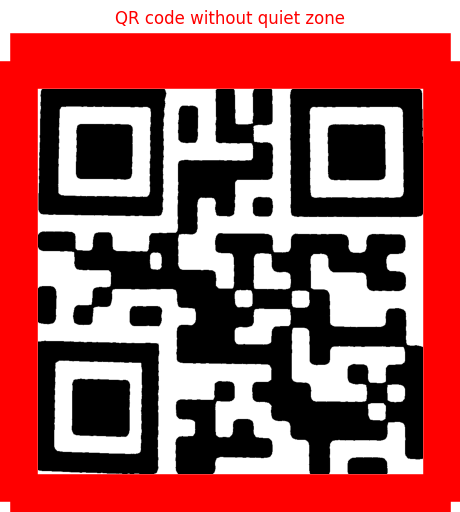

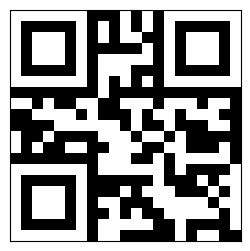

In [759]:
qr_no_quiet_zone = img[start_row:end_row, start_col:end_col]


if QR_CODE_VERSION == 1 and start_row != 44 and end_row!= 968:
    # Function to calculate the percentage of black pixels in each row and column
    def calculate_black_pixel_percentage(image):
        row_percentages = np.mean(image == 255, axis=1)
        col_percentages = np.mean(image == 255, axis=0)
        return row_percentages, col_percentages

    # Threshold for the percentage of black pixels allowed in a row or column
    BLACK_PIXEL_PERCENTAGE_THRESHOLD = 1.0

    # Calculate black pixel percentages
    row_percentages, col_percentages = calculate_black_pixel_percentage(qr_no_quiet_zone)

    # Find rows and columns to remove
    rows_to_remove = np.where(row_percentages >= BLACK_PIXEL_PERCENTAGE_THRESHOLD)[0]
    cols_to_remove = np.where(col_percentages >= BLACK_PIXEL_PERCENTAGE_THRESHOLD)[0]

    # Remove rows and columns with high black pixel percentages
    qr_no_quiet_zone = np.delete(qr_no_quiet_zone, rows_to_remove, axis=0)
    qr_no_quiet_zone = np.delete(qr_no_quiet_zone, cols_to_remove, axis=1)


fig = plt.figure(figsize=(5, 5))
plt.xticks([], [])
plt.yticks([], [])
fig.get_axes()[0].spines[:].set_color('red')
fig.get_axes()[0].spines[:].set_linewidth(40)
fig.get_axes()[0].spines[:].set_position(("outward", 20))
plt.title('QR code without quiet zone', y=1.15, color='red')
plt.imshow(qr_no_quiet_zone, cmap='gray')

if QR_CODE_VERSION==1:
    image_grid_fin = cv2.resize(qr_no_quiet_zone, (21, 21), interpolation=cv2.INTER_LINEAR) // 255
    image_grid_fin = 1 - image_grid_fin
elif QR_CODE_VERSION == 3:
    image_grid_fin = cv2.resize(qr_no_quiet_zone, (29, 29), interpolation=cv2.INTER_LINEAR) // 255
    image_grid_fin = 1 - image_grid_fin
fig = plt.figure(figsize=(3, 3));
plt.xticks([], []);
plt.yticks([], []);
plt.imshow(image_grid_fin, cmap='gray');
print(image_grid_fin.shape)

## Use locator boxes to determine grid size
Since we know that the topleft pixel should be the border of the locator box, and that its size should be 7×7, we can determine the grid cell size by dividing its size in pixels by 7. How to get its size? It is a constant black row of pixels followed by one white cell. A simple for loop can get it done.

Grid cell size:  44
QR code shape: (924, 924)
Shape of qr_cells: (21, 21, 44, 44)


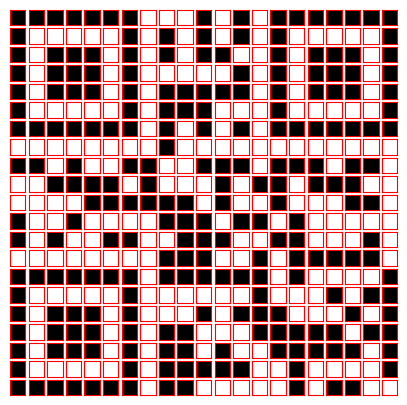

In [760]:
try:
# Initialize a list to store the counts of non-zero pixels at each position
    pixel_counts = [0] * len(qr_no_quiet_zone[0])

    # # Iterate over the first 10 rows
    for row in qr_no_quiet_zone[:10]:
        for i, pixel in enumerate(row):
            # Check if the pixel is non-zero
            if (pixel != 0).any():
                # Increment the count for this position
                pixel_counts[i] += 1
    #
    # # Find the position with the maximum count
    # most_common_position = np.argmax(pixel_counts)
    # print(most_common_position)

    grid_cells_num = qr_code_version_grids
    qr_max_length = max(qr_no_quiet_zone.shape[0], qr_no_quiet_zone.shape[1])
    grid_cell_size = int(math.sqrt(int(qr_max_length ** 2) / (grid_cells_num ** 2)))
    print("Grid cell size: ", grid_cell_size)

    print("QR code shape:", qr_no_quiet_zone.shape)
    # Reshape the image into grid cells
    qr_cells = qr_no_quiet_zone.reshape((grid_cells_num, grid_cell_size, grid_cells_num, grid_cell_size)).swapaxes(1, 2)
    print("Shape of qr_cells:", qr_cells.shape)
    # Fill each grid cell with the majority color
    for i in range(grid_cells_num):
        for j in range(grid_cells_num):
            cell = qr_cells[i][j]
            black_pixels = np.sum(cell == 0)
            white_pixels = np.sum(cell == 255)
            if black_pixels > white_pixels:
                qr_cells[i][j] = np.zeros_like(cell)
            else:
                qr_cells[i][j] = np.ones_like(cell) * 255

    # Plot the modified grid cells
    _, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(5, 5))
    for i, row in enumerate(axes):
        for j, col in enumerate(row):
            col.imshow(qr_cells[i][j], cmap="gray", vmin=0, vmax=255)
            col.get_xaxis().set_visible(False)
            col.get_yaxis().set_visible(False)
            col.spines[:].set_color('red')

except Exception as e:

    print("Error:", e)

## Convert grid tiles to numeric values

In [761]:
try:
    qr_cells_numeric = np.ndarray((grid_cells_num, grid_cells_num), dtype=np.uint8)
    for i, row in enumerate(qr_cells):
        for j, cell in enumerate(row):
            qr_cells_numeric[i, j] = (np.median(cell) // 255)
    print(qr_cells_numeric)
    plt.show()
except Exception as e:
    print("Error: ", e)

[[0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 0]
 [0 1 0 0 0 1 0 1 0 1 0 0 1 1 0 1 0 0 0 1 0]
 [0 1 0 0 0 1 0 1 1 1 1 1 0 1 0 1 0 0 0 1 0]
 [0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0]
 [0 1 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 1 1 1 0]
 [0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 1 0 1 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1]
 [1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 1 0 0 0 1 1]
 [1 1 1 1 0 0 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1]
 [0 1 1 0 1 1 1 1 0 0 0 1 0 0 1 0 1 1 1 1 1]
 [0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 0 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 1 0]
 [0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 0]
 [0 1 0 0 0 1 0 1 1 1 0 1 0 0 0 1 1 1 0 1 0]
 [0 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0]
 [0 1 1 1 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0]
 [0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 1 1]]


## Information extraction

![Alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/QR_Format_Information.svg/640px-QR_Format_Information.svg.png "a title")


### Error correction level

In [762]:
print(qr_cells_numeric[8])

[0 0 1 0 1 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1]


The first two bits of formatting information give the error correction level used for the message data. A QR symbol this size contains 26 bytes of information. Some of these are used to store the message and some are used for error correction, as shown in the table below. The left-hand column is simply a name given to that level.

Error Correction Level	| Level Indicator |	Error Correction Bytes |Message Data Bytes
            L	        |       01	      |            7	       |      19
            M	        |       00	      |            10	       |      16
            Q	        |       11	      |            13	       |      13
            H	        |       10	      |            17	       |      9


In [763]:

#FOR REED SOLOMON WE WILL CHANGE THESE
# The first two bits determine the error correction level
# Level L (Low)         [11]	7%  of data bytes can be restored.
# Level M (Medium)      [10]	15% of data bytes can be restored.
# Level Q (Quartile)    [01]	25% of data bytes can be restored.
# Level H (High)        [00]	30% of data bytes can be restored.


error_correction_byes = 0
message_data_bytes = 0
ecl1 = []
for i in range(19, 21):
    ecl1.append(int(image_grid_fin[i, 8]))
print("ECL1:", ecl1)
ecl = image_grid_fin[8, 0:2]
print("ECL:", ecl)

if (ecl1 == ecl).all():
    print("ECL correct:", ecl)
else:
    ecl = np.maximum(ecl, ecl1)
    print("Chosen Error Correction Level:", ecl)


if (ecl == [0, 0]).all():
    print("level: High")
    error_level = 'H'
    error_correction_byes = 17
    message_data_bytes = 9

elif (ecl == [0, 1]).all():
    print("level: Quartile")
    error_level = 'Q'
    error_correction_byes = 13
    message_data_bytes = 13

elif (ecl == [1, 0]).all():
    print("level: Medium")
    error_level = 'M'
    error_correction_byes = 10
    message_data_bytes = 16

elif (ecl == [1, 1]).all():
    print("level: Low")
    error_level = 'L'
    error_correction_byes = 7
    message_data_bytes = 19

print("chosen ecl: ", ecl)
# mask_pattern(qr_cells_numeric)

ECL1: [1, 1]
ECL: [1 1]
ECL correct: [1 1]
level: Low
chosen ecl:  [1 1]


### Mask pattern

In [764]:
# Dictionary of all masks and their equivalent formulae
# P.S. I modified them to account for that I skipped the FEC mask part above
# If you will do it, do not XOR the mask if you wish to use this MASKS table
MASKS = {
    "000": lambda i, j: (i * j) % 2 + (i * j) % 3 == 0,
    "001": lambda i, j: (i // 2 + j // 3) % 2 == 0,
    "010": lambda i, j: ((i + j) % 2 + (i * j) % 3) % 2 == 0,
    "011": lambda i, j: ((i * j) % 2 + (i * j) % 3) % 2 == 0,
    "100": lambda i, j: i % 2 == 0,
    "101": lambda i, j: (i + j) % 2 == 0,
    "110": lambda i, j: (i + j) % 3 == 0,
    "111": lambda i, j: j % 3 == 0,
}
# Enum for the different directions of reading blocks in the QR code
# The number indicates how many bytes are in this block
UP8, UP4, DOWN8, DOWN4, CW8, CCW8, LEN9 = range(7)
# Same row as above, the three cells after the ecl cells (converted to a string)
mask1 =  image_grid_fin[16:19, 2]
print(mask1)
mask = image_grid_fin[8, 2:5]
print(mask)

# Compare masks
if (mask == [0, 0, 0]).all():
    # print("Mask is [0 0 0]")
    mask = np.maximum(mask, mask1)
    print("Chosen mask:", mask)


print("Chosen mask:", mask)


[1 1 1]
[0 1 0]
Chosen mask: [0 1 0]


### Format error correction

In [765]:
# Same row as above, but we want cells #5 and #7 (#6 is always set to 0),
#  followed by column #8 from cell #0 in it to cell #7 (and skipping #6)
fec = []
fec.append(qr_cells_numeric[8, 5])
fec.append(qr_cells_numeric[8, 7])
fec.extend(qr_cells_numeric[0:6, 8])
fec.extend(qr_cells_numeric[7:9, 8])
fec = [int(not (c)) for c in fec]
print(fec)
# FEC from another location
fec2 = []
fec2.append(qr_cells_numeric[15, 8])
fec2.append(qr_cells_numeric[14, 8])
fec2.extend(qr_cells_numeric[8, 13:21][::-1])
fec2 = [int(not (c)) for c in fec2]
print("FEC from another location:", fec2)

# Compare FECs
if fec == fec2:
    print("FECs are the same")
else:
    print("FECs are different")

# Choose the maximum FEC value
# fec = max(fec, fec2)
# print("Chosen FEC:", fec)

# print(fec)

[0, 1, 0, 1, 1, 0, 1, 1, 1, 0]
FEC from another location: [0, 1, 0, 1, 1, 0, 1, 1, 1, 0]
FECs are the same


In [766]:
# So in total we have the following 15 bits of format info from our QR code
print(ecl, mask, fec)

[1 1] [0 1 0] [0, 1, 0, 1, 1, 0, 1, 1, 1, 0]


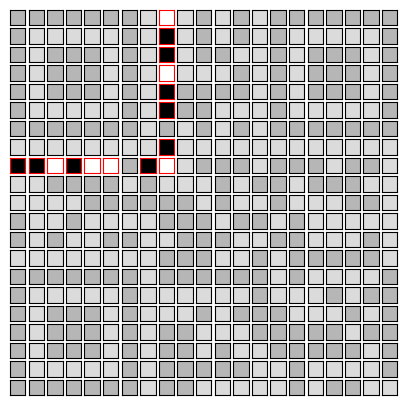

In [767]:

# Let's cross-check with our example
_, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(5, 5))
for i, row in enumerate(axes):
    for j, col in enumerate(row):

        col.get_xaxis().set_visible(False)
        col.get_yaxis().set_visible(False)
        if (i == 8 and j <= 8) or (i <= 8 and j == 8):
            if (i != 6) and (j != 6):
                col.imshow(qr_cells[i][j], cmap="gray", vmin=0, vmax=255)
                col.spines[:].set_color('red')
                continue
        col.imshow(qr_cells[i][j], cmap="gray", vmin=-1275, vmax=510)
    # print(ecl, mask, fec)

The masking transformation is easily applied (or removed) using the exclusive-or operation (denoted by a caret ^ in many programming languages). The unmasking of the format information is shown below. Reading counter-clockwise around the upper-left locator pattern, we have the following sequence of bits. White modules represent 0 and black modules represent 1.

Input       101101101001011
Mask      ^ 101010000010010
Output      000111101011001

In [768]:
# # However..... You need to XOR that with the "format mask": 101010000010010
# ecl[0] ^= 1
# mask[0] ^= 1
# mask[2] ^= 1
# fec[5] ^= 1
# fec[8] ^= 1
#
# # And now we print...
# print(ecl, mask, fec)
#
# # ecl = ecl

Data extraction
Message placement within a Ver 1 QR symbol (21×21).
![Alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/QR_Character_Placement.svg/640px-QR_Character_Placement.svg.png "a title")
Message placement within a Ver 1 QR symbol (21×21). Example from wikipedia, encoded QR message is www.wikipedia.org

## Data extraction


In [769]:
# A more general apply_mask function (still works the same way)
def apply_mask_general(data_start_i, data_start_j, data, mask, direction):
    result = []
    row_offsets = []
    col_offsets = []
    mask_str = ''.join([str(c) for c in mask])
    if (direction in [UP8, UP4]):
        row_offsets = [0,  0, -1, -1, -2, -2, -3, -3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction in [DOWN8, DOWN4]):
        row_offsets = [0,  0,  1,  1,  2,  2,  3,  3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == CW8):
        row_offsets = [0,  0,  1,  1,  1,  1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    if (direction == CCW8):
        row_offsets = [0,  0, -1, -1, -1, -1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    if (direction == LEN9):
        row_offsets = [0,  0, -1, -1, -2, -2, -3, -3,-4]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1, 0]
    for i, j in zip(row_offsets, col_offsets):
        cell_bit = bool(data[data_start_i+i, data_start_j+j])
        mask_bit = MASKS[mask_str](data_start_i+i, data_start_j+j)
        # Modules corresponding to the dark areas of the mask are inverted.
        result.append(int(not cell_bit if mask_bit else cell_bit))
    return result[:4] if direction in [UP4, DOWN4] else result

### Data encoding

In [770]:
enc_bits = apply_mask_general(grid_cells_num - 1, grid_cells_num - 1, image_grid_fin, mask, UP4)
# grid_cells_num = 21 - 1 -> [20, 20]
print(enc_bits)

length_bits = 0
mode = ''

if enc_bits == [0,0,0,1]:
    print("Mode name: Numeric")
    print("Data bits: 10 bits per 3 digits")
    length_bits = 10
    mode = "numeric"

elif enc_bits == [0,0,1,0]:
    print("Mode name: Alphanumeric")
    print("Data bits: 11 bits per 2 characters")
    length_bits = 9
    mode = "alphanumeric"


elif enc_bits == [0,1,0,0]:
    print("Mode name: Byte")
    print("Data bits: 8 bits per character")
    length_bits = 8
    mode = "byte"


elif enc_bits == [1,0,0,0]:
    print("Mode name: Kanji")
    print("Data bits: 13 bits per character")
    length_bits = 8
    mode = "kanji"
else:
    enc_bits == [0,1,0,0]
    print("Mode name: Byte")
    print("Data bits: 8 bits per character")
    length_bits = 8
    mode = "byte"


[0, 0, 1, 0]
Mode name: Alphanumeric
Data bits: 11 bits per 2 characters


### Data length

In [771]:
if mode == "alphanumeric":
    len_bits = apply_mask_general(grid_cells_num - 3, grid_cells_num - 1, image_grid_fin, mask, LEN9)
    len_int = int(''.join([str(bit) for bit in len_bits]), 2)
    print(f'ECL = {ecl}\nMASK = {mask}\nENC = {enc_bits}\nLEN = {len_bits} = {len_int} data symbols, each consisting of 8 bits')
else:
    len_bits = apply_mask_general(grid_cells_num - 3, grid_cells_num - 1, image_grid_fin, mask, UP8)
    len_int = int(''.join([str(bit) for bit in len_bits]), 2)
    print(f'ECL = {ecl}\nMASK = {mask}\nENC = {enc_bits}\nLEN = {len_bits} = {len_int} data symbols, each consisting of 8 bits')

ECL = [1 1]
MASK = [0 1 0]
ENC = [0, 0, 1, 0]
LEN = [0, 0, 0, 0, 0, 1, 1, 0, 1] = 13 data symbols, each consisting of 8 bits


### Data extraction

In [772]:
print("grid cells number: ",grid_cells_num)
block_starting_indices = [
    [grid_cells_num-7,  grid_cells_num-1,  UP8],
    [grid_cells_num-11, grid_cells_num-1,  CCW8],
    [grid_cells_num-10, grid_cells_num-3,  DOWN8],
    [grid_cells_num-6,  grid_cells_num-3,  DOWN8],
    [grid_cells_num-2,  grid_cells_num-3,  CW8],
    [grid_cells_num-3,  grid_cells_num-5,  UP8],
    [grid_cells_num-7,  grid_cells_num-5,  UP8],
    [grid_cells_num-11, grid_cells_num-5,  CCW8],
    [grid_cells_num-10, grid_cells_num-7,  DOWN8],
    [grid_cells_num-6,  grid_cells_num-7,  DOWN8],
    [grid_cells_num-2,  grid_cells_num-7,  CW8],
    [grid_cells_num-3,  grid_cells_num-9,  UP8],
    [grid_cells_num-7,  grid_cells_num-9,  UP8],
    [grid_cells_num-11, grid_cells_num-9,  UP8],
    [grid_cells_num-16, grid_cells_num-9,  UP8],
    [grid_cells_num-20, grid_cells_num-9,  CCW8],
    [grid_cells_num-19, grid_cells_num-11, DOWN8],
    [grid_cells_num-14, grid_cells_num-11, DOWN4],  # Special 4-byte block, reserved for END (if exists!)
    [grid_cells_num-12, grid_cells_num-11, DOWN8],
    [grid_cells_num-8,  grid_cells_num-11, DOWN8],
    [grid_cells_num-4,  grid_cells_num-11, DOWN8],
    [grid_cells_num-9,  grid_cells_num-13, UP8],
    [grid_cells_num-12, grid_cells_num-16, DOWN8],
    [grid_cells_num-9,  grid_cells_num-18, UP8],
    [grid_cells_num-12, grid_cells_num-20, DOWN8],
]
ans = ''
listeddd = []
message_bits = []
message_bits.extend(enc_bits)
message_bits.extend(len_bits)
# First, let's read the data bytes, starting from the very first byte after enc and len
byte_index = 0
try:
    for _ in range(len_int):
        start_i, start_j, dir = block_starting_indices[byte_index]
        bits = apply_mask_general(start_i, start_j, image_grid_fin, mask, dir)
        message_bits.extend(bits)
        bit_string = ''.join([str(bit) for bit in bits])
        alpha_char = chr(int(bit_string, 2))
        listeddd.append(bit_string)
        ans += alpha_char # converts to binary to int, then to ASCII
        print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')
        byte_index += 1

    # After finishing all the characters, the next 4 bits are expected to be '0000'
    start_i, start_j, dir = block_starting_indices[byte_index]
    bits = apply_mask_general(start_i, start_j, image_grid_fin, mask, dir)
    message_bits.extend(bits)
    bit_string = ''.join([str(bit) for bit in bits])
    listeddd.append(bit_string)
    print(f'{bit_string} (=END) -- the NULL TERMINATOR, followed by padding and/or ECC')
    byte_index += 1
except:
    print(f'\nDecoded string: {ans}')



# Let's see what the bytes that follow look like
# There supposedly remain 25-len-1 bytes to be read
for _ in range(25 - len_int - 1):
    start_i, start_j, dir = block_starting_indices[byte_index]
    bits = apply_mask_general(start_i, start_j, image_grid_fin, mask, dir)
    message_bits.extend(bits)
    bit_string = ''.join([str(bit) for bit in bits])
    # listeddd.append(bit_string)
    alpha_char = chr(int(bit_string, 2))
    print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')
    byte_index += 1

# For every 8 bits in the extracted message, convert to a byte
# message_bits[3] = 1

message_bytes = [int("".join(map(str, message_bits[i:i+8])), 2) for i in range(0, len(message_bits), 8)]

if mode != "alphanumeric":
# if
    try:
        print("error correction bytes: ", error_correction_byes)
        # Create the Reed-Solomon Codec for 7 ECC symbols (again, this is L)
        rsc = rs.RSCodec(nsym=error_correction_byes)

        # Decode the bytes with the 7-ECC RS Codec
        message_decoded = rsc.decode(message_bytes)
        rsc.maxerrata(verbose=True)

        # In order to extract the actual data, need to convert back to bits
        # Then take as many bytes as indicated by the message length indicator
        # That is AFTER removing the first 12 bytes (of enc and len)
        data_bits = bin(int.from_bytes(message_decoded[0], byteorder='big'))[13:13+len_int*8]

        # Now convert back to bytes and print it lol
        data_bytes = int(data_bits, 2).to_bytes((len(data_bits)+7)//8, 'big')
        print(f'Data in message = "{data_bytes.decode(encoding="iso-8859-1")}"')
        # print(f'Data should be... "01-Good job!"')
    except Exception as e:
        print("Error:", e)
        print(f'\nDecoded string: {ans}')


else:
# Print the updated data_starting_indices list
    bits_list = []

    for binary_string in listeddd:
        bits_list.extend(list(map(int, binary_string)))
    ALPHANUMERIC_TABLE = {
        0: '0', 1: '1', 2: '2', 3: '3', 4: '4',
        5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
        10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E',
        15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J',
        20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O',
        25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T',
        30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y',
        35: 'Z', 36: ' ', 37: '$', 38: '%', 39: '*',
        40: '+', 41: '-', 42: '.', 43: '/', 44: ':'
    }

    def decode(bits):
        # Convert the 11-bit binary string to an integer
        num = int(bits, 2)

        # Divide the number by 45 to get the first character
        first_num = num // 45
        first_char = ALPHANUMERIC_TABLE[first_num]

        # Use modulus to get the second character
        second_num = num % 45
        second_char = ALPHANUMERIC_TABLE[second_num]

        return first_char + second_char

    bits_list_alpha = bits_list[1:]
    # Decode the reversed bits
    alpha_counter = 0
    chunks_list = []
    decoded_string = ''
    for i in range(0, len(bits_list_alpha), 11):
        chunk = bits_list_alpha[i:i+11]

        if len_int % 2 == 1:
            if len(decoded_string) == len_int - 1:
                # If length of decoded_string is equal to len_int - 1, break the loop
                # Check if it's the last chunk with 6 bits
                chunk = bits_list_alpha[i:i+6]
                first_char, last_char = decode(''.join(map(str, chunk)))
                decoded_string += last_char
                break
            if len(chunk) == 11:
                # Ensure the chunk has 11 bits
                first_char, second_char = decode(''.join(map(str, chunk)))
                decoded_string += first_char + second_char
        else:
            chunk = bits_list_alpha[i:i+11]
            # chunks_list.append(chunk)
            if len(decoded_string) > len_int-2:
                break
            if len(chunk) == 11:  # Ensure the chunk has 11 bits
                first_char, second_char = decode(''.join(map(str, chunk)))
                decoded_string += first_char + second_char

    print("Mode is alphanumeric, the above decoded bit strings are in byte mode")
    print("Decoding in alphanumeric......")
    print("Decoded string: ", decoded_string)


# print(bits_list)

grid cells number:  21
10011111 (=159) = 
10011000 (=152) = 
00101011 (=043) = +
00000101 (=005) = 
01001110 (=078) = N
01100001 (=097) = a
11001100 (=204) = Ì
00111001 (=057) = 9
10000101 (=133) = 
00000000 (=000) =  
00001110 (=014) = 
11000001 (=193) = Á
00011110 (=030) = 
11000001 (=END) -- the NULL TERMINATOR, followed by padding and/or ECC
00011110 (=030) = 
11000001 (=193) = Á
00011110 (=030) = 
1100 (=012) = 
01011001 (=089) = Y
00010110 (=022) = 
00110011 (=051) = 3
10010000 (=144) = 
01110011 (=115) = s
00010101 (=021) = 
10111100 (=188) = ¼
Mode is alphanumeric, the above decoded bit strings are in byte mode
Decoding in alphanumeric......
Decoded string:  BANANAAAAAAAA
